In [317]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numba import jit
%matplotlib inline

In [318]:
X,Y,Z = 1000,1000,100
bounding_center_default = np.array([50,500,500])

def generate_points(origin,n,square_rad=[15,100,100]):
    #ive hard coded the bounding rs - careful
    zs = np.random.normal(origin[0],square_rad[0],n)
    ys = np.random.normal(origin[1],square_rad[1],n)
    xs = np.random.normal(origin[2],square_rad[2],n)
    
    return np.stack([zs,ys,xs]).T#.shape

def transformer(shift_params,noise_params):
    def _t_(A):
        N = len(A)
        v=np.stack([np.random.normal(*shift_params)])
        Q = np.eye(v.shape[1]+1)
        Q[:v.shape[1],-1] = np.array(v)
        Q = np.matrix(Q)
        #then need small noise to each to each point so it is not a precise translation
        noise= np.random.normal(*noise_params[:2],(N,3))
        #extend A dims
        _A = np.matrix(np.hstack((A,np.ones((len(A),1)))))
        _A = np.array(np.dot(_A, Q.T)) 
        return _A[:,:3] + noise     
    return _t_

def not_in_bounds(v, bounds=(X,Y,Z)):
    if np.min(v) < 0: return True
    #careful = z,y,z, order?
    if v[:,0].max() >= Z or v[:,1].max() >= Y or v[:,2].max() >= X:return False
    return False

def join(v1,v2):return np.concatenate([v1,v2],axis=1)

def transform_points_reflecting(inliers, 
                                bounding_center=bounding_center_default, 
                                parameters=[(0,7,3),(0,1,3)], 
                                marriages = [], 
                                size=(250,250,25)):
    """
    the inliner points sit in the bounding box and we make sure the bounding box stays in the outer box of dimensions X,Y,Z
    The surrogate data tool needs to know about point identities which we record in marriages - this is the ground truth
    A tracker should make the same point-point marriages
    """

    t = None
    safety = 0
    while True:#not safe but ok if supervised
        if safety > 100: 
            raise Exception("timeout")
        #this is a little messy but im using a list of tuples for the parameters for translations, noise or whatever
        t = transformer(parameters[0], parameters[1])
        #update the bounding box center 
        bounding_center = t(np.stack([bounding_center]) )[0] 
        #get the box - what we really need are the bounds to check we stay in outer bounds
        box = np.stack([[bounding_center[i] + size[i], bounding_center[i] - size[i]] for i in range(3)])
        #check that the extreme points of the box are in bounds
        if not_in_bounds(np.stack([box[:,0],box[:,1]]) ):
            continue
        break
        
        
    #use valid transfrormation    
    projected = t(inliers)
    #udpate the marriages if it is what the caller wants
    if marriages != None:marriages.append(join(inliers,projected))
    #return new projected, bounding center and marriages as a side-effect
    return projected, bounding_center

def transform_points_wrapping(outliers,  parameters):
    """
    for the outliers, we just keep them wrapped ("toroidal" boundary conditions) and moving accross the field of view
    """
    t = transformer(parameters)
    return wrapped( t(outliers) )


def save_images(v,u,f):
    plt.figure(figsize=(20,15))
    data = pd.DataFrame(v,columns=["z", "y", "x"])
    ax=plt.scatter(data.x, data.y, s=25, c='r')
    data = pd.DataFrame(u,columns=["z", "y", "x"])
    ax=plt.scatter(data.x, data.y, s=15, c='k')
    plt.xlim(0,1000)
    plt.ylim(0,1000)
    plt.savefig(f)
    plt.close()

    
def bandd(v,l,i,bc, r=0.03):
    v=v[l > i] #keep everything that is still alive after time i
    l=l[l>i]
    #use a population dependent creation policy with appropriate birth rate r
    birth_count = np.sum(np.random.binomial(n=1, p=r, size=20))   
    if birth_count>0:#create new items
        #create new lifetimes
        l_new = np.random.binomial(n=7, p=0.5, size=birth_count) + i
        #create tnew
        v_new = generate_points(bc, birth_count)
        v = np.concatenate([v,v_new])
        l = np.concatenate([l,l_new])
        
    return v,l

def wrapped(v): pass

#todo - some possible outliers movement

In [397]:
#this block will become a parameterized function

N = 50

initial_points = 15
noise_points = 2

marriages = []
bc = bounding_center_default

lifetimes = np.random.binomial(n=7, p=0.5, size=initial_points)
inliers = generate_points(bc,initial_points)
outliers = generate_points(bc,square_rad=[30,200,200],n=noise_points)

track_data = [np.concatenate([tag_array(inliers,1),tag_array(outliers,0)])]

tag_array = lambda v,k : np.c_[v, [k for i in range(len(v))] ]

for i in range(N):   
    #random outliers no move

    save_images(inliers, outliers, "./samples//temp/F{:0>4}.png".format(i))
    #find the new locations for the inliers and record marriags - the function works as is but i could closure it for other params
    _inliers,bc = transform_points_reflecting(inliers, bounding_center=bc, marriages=marriages)
    #update inliers
    inliers = _inliers.copy()
    #now create or destory individuals using given lifetimes or creation rates
    inliers,lifetimes = bandd(inliers, lifetimes, i, bc, r=0.2)
    outliers = generate_points(bc,square_rad=[30,200,200],n=noise_points)
    print(".", end="")
    #print(i, len(outliers))
    track_data.append(  np.concatenate([tag_array(inliers,1),tag_array(outliers,0)]))
    #move the outliers
    #outliers = outliers_transformer(outliers)
print("done")
all_df = []
for i,v in enumerate(track_data):
    df = pd.DataFrame(v, columns=["z", "y", "x", "in"])
    df["t"] = i
    all_df.append(df)
all_df= pd.concat(all_df)
all_df["in"] = all_df["in"].astype(int)

..................................................done


In [398]:
def make_hash(row):
    lkeys = ["x", "y", "z"]
    rkeys = ["xlast", "ylast", "zlast"]
    l = [str(round(row[f],3)) for f in lkeys if pd.notnull(row[f]) ]
    r = [str(round(row[f],3)) for f in rkeys if pd.notnull(row[f])]
    
    if len(l)>0 and len(r) > 0: return "M"+ "_".join(l)+"__"+"_".join(r)
    elif len(l) ==0: return "D"+"_".join(r)
    elif len(r) ==0: return "B"+"_".join(l)
    
    
def event_type(row):
    return row["hash"][:1]

#merge the marriages
ad = all_df.set_index(["x", "y", "z"])
newdfs = []
for t, a in ad.groupby("t"):
    if t ==0: continue
    m0=pd.DataFrame(marriages[t-1], columns=["zlast", "ylast", "xlast", "z", "y", "x"])
    m0["t"] = t
    m0 = m0.set_index(["x", "y","z"])
    a= a[a.t==t].copy()
    ref = a.join(m0, how='inner', rsuffix="l")
    ref.index.values
    a["married"] = 0
    a.ix[ref.index,"married"] = 1
    a = a.join(m0,how='left', rsuffix='m_')
    newdfs.append(a)
newdfs = pd.concat(newdfs).reset_index()
newdfs["hash"] = newdfs.apply(make_hash,axis=1)
newdfs["type"] = newdfs.apply(event_type,axis=1)

newdfs.head()
#the right way to do this will be to rebuild a new dataframe by joining on the marriages by index per time point
#then we can generate a hash for marriage arriving at t
#then we can test the tracker for t>= 1 to see how many of the actual joint keys in matches - again we rebuild a dataframe joining on the hash
#we can etiher left join on hash to get precision or outer join to detect false positives and false negatives 
#we also have enough inforamtion re: last to plot both sets and draw the matches
#then I need to think about updating the surrogate to have a min separation

,x,y,z,in,t,married,zlast,ylast,xlast,tm_,hash,type
0,571.341909,445.858762,64.005480,1,1,1,65.807932,440.354337,565.143700,1.0,M571.342_445.859_64.005__565.144_440.354_65.808,M
1,402.366503,517.129077,47.807628,1,1,1,49.356228,509.593021,396.283841,1.0,M402.367_517.129_47.808__396.284_509.593_49.356,M
2,439.080340,513.434230,53.084332,1,1,1,54.759819,506.430879,432.492599,1.0,M439.08_513.434_53.084__432.493_506.431_54.76,M
3,545.081529,269.446927,51.051901,1,1,1,51.063580,260.956507,540.821430,1.0,M545.082_269.447_51.052__540.821_260.957_51.064,M
4,570.969685,640.096596,54.000844,1,1,1,57.049433,631.039000,565.205057,1.0,M570.97_640.097_54.001__565.205_631.039_57.049,M


(0, 1000)

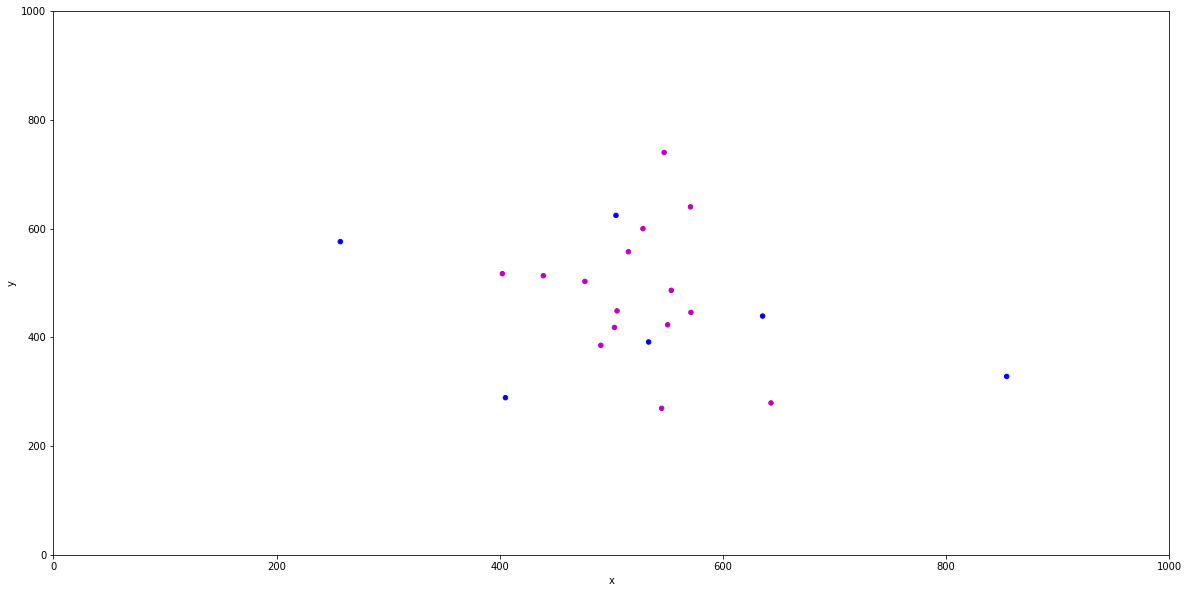

In [399]:
plottable = newdfs[newdfs.t==1]
ax = plottable.plot(kind='scatter', x='x', y='y',s=20, c=plottable['type'],  figsize=(20,10))
ax.set_ylim(0,1000)
ax.set_xlim(0,1000)
#more sophisciated plot function: draw the previous time as well with xs for outliers and gray circles for inlinears
#then for the married stuff in the current frame maybe make the size bigger 
#might be useful to use circle instead of filled for t-1 when the inlier dies
#when we join on the tracker data, we can use green and red dotted lines if they are true or not - somewhere we do the sums too

In [400]:
all_df.to_csv("./samples/surrogate.csv")

In [401]:
from lightroot.tracking import tpctree
from lightroot import plots
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
%matplotlib inline
result = tpctree.process_file("./samples/surrogate.csv",start=0,end=5,
                              options={"transforms":True, 
                                       "epsilon":30, 
                                       "sample_size":200,
                                       "use_tr_concensus": True,
                                       "debug": False,
                                       "lags" : [1]
                                      })

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.71s/it]


In [402]:
#foreach transition i can extract what was married by joining on id, and then i can look at the inferred deaths and creations
#metrics - the number of marriages out of all possible, the number of false positives (actually new) and false negatives (actually not new)
merged = []
for k, g in result.data.groupby("t"):
    if k == 1:continue
    df = g.set_index("key")
    merged.append(df.join(result.data[result.data["t"]==k-1],  how="outer", rsuffix="last"))
merged=pd.concat(merged)
merged.head(10)

,angles,epsilon1,t,x,y,z,angleslast,epsilon1last,key,tlast,xlast,ylast,zlast
0,None,2.649171,2.0,571.341909,445.858762,64.005480,None,NaN,0.0,1.0,565.143700,440.354337,65.807932
1,None,0.797717,2.0,402.366503,517.129077,47.807628,None,NaN,1.0,1.0,396.283841,509.593021,49.356228
2,None,1.494544,2.0,439.080340,513.434230,53.084332,None,NaN,2.0,1.0,432.492599,506.430879,54.759819
3,None,2.251300,2.0,545.081529,269.446927,51.051901,None,NaN,3.0,1.0,540.821430,260.956507,51.063580
4,None,1.598194,2.0,570.969685,640.096596,54.000844,None,NaN,4.0,1.0,565.205057,631.039000,57.049433
5,None,2.093065,2.0,476.322968,502.893057,34.479011,None,NaN,5.0,1.0,472.478197,494.267760,35.209673
6,None,2.603620,2.0,528.336085,600.046860,44.795985,None,NaN,6.0,1.0,522.492544,593.940960,48.282679
7,None,1.730297,2.0,490.591268,385.328339,50.132954,None,NaN,7.0,1.0,483.558962,377.926948,52.534663
8,None,1.231309,2.0,643.091283,279.336965,49.400821,None,NaN,8.0,1.0,636.568033,270.504850,51.201261
9,None,1.127788,2.0,550.459509,423.105830,53.741153,None,NaN,9.0,1.0,545.361346,415.772164,54.829026


In [403]:
m=merged[["t", "tlast", "x", "y", "z", "xlast", "ylast", "zlast"]]
m["t"]=m['t'].fillna(m['tlast']+1)
m["tlast"]=m['tlast'].fillna(m['t']-1)
m['t'] = m['t'].astype(int)
m['tlast'] = m['tlast'].astype(int)
m["hash"] = m.apply(make_hash,axis=1)
m["type"] = m.apply(event_type,axis=1)
#zero index
m["t"] = m["t"] - 1
m["tlast"] = m["tlast"] - 1
m[m["t"] ==1]

,t,tlast,x,y,z,xlast,ylast,zlast,hash,type
0,1,0,571.341909,445.858762,64.005480,565.143700,440.354337,65.807932,M571.342_445.859_64.005__565.144_440.354_65.808,M
1,1,0,402.366503,517.129077,47.807628,396.283841,509.593021,49.356228,M402.367_517.129_47.808__396.284_509.593_49.356,M
2,1,0,439.080340,513.434230,53.084332,432.492599,506.430879,54.759819,M439.08_513.434_53.084__432.493_506.431_54.76,M
3,1,0,545.081529,269.446927,51.051901,540.821430,260.956507,51.063580,M545.082_269.447_51.052__540.821_260.957_51.064,M
4,1,0,570.969685,640.096596,54.000844,565.205057,631.039000,57.049433,M570.97_640.097_54.001__565.205_631.039_57.049,M
5,1,0,476.322968,502.893057,34.479011,472.478197,494.267760,35.209673,M476.323_502.893_34.479__472.478_494.268_35.21,M
6,1,0,528.336085,600.046860,44.795985,522.492544,593.940960,48.282679,M528.336_600.047_44.796__522.493_593.941_48.283,M
7,1,0,490.591268,385.328339,50.132954,483.558962,377.926948,52.534663,M490.591_385.328_50.133__483.559_377.927_52.535,M
8,1,0,643.091283,279.336965,49.400821,636.568033,270.504850,51.201261,M643.091_279.337_49.401__636.568_270.505_51.201,M
9,1,0,550.459509,423.105830,53.741153,545.361346,415.772164,54.829026,M550.46_423.106_53.741__545.361_415.772_54.829,M


In [404]:
chk1= m[m.t==1].set_index(["x", "y", "z"])
chk2 = newdfs[newdfs.t==1].set_index(["x", "y", "z"])
chk2.join(chk1, how="inner",rsuffix='l')

,,,in,t,married,zlast,ylast,xlast,tm_,hash,type,tl,tlast,xlastl,ylastl,zlastl,hashl,typel
x,y,z,,,,,,,,,,,,,,,,
257.162470,576.106026,243.605598,0,1,0,NaN,NaN,NaN,NaN,B257.162_576.106_243.606,B,1,0,NaN,NaN,NaN,B257.162_576.106_243.606,B
504.155089,624.368860,245.491812,1,1,0,NaN,NaN,NaN,NaN,B504.155_624.369_245.492,B,1,0,NaN,NaN,NaN,B504.155_624.369_245.492,B
505.104941,448.688121,42.977687,1,1,1,44.073287,439.400728,498.109056,1.0,M505.105_448.688_42.978__498.109_439.401_44.073,M,1,0,498.109056,439.400728,44.073287,M505.105_448.688_42.978__498.109_439.401_44.073,M
533.414296,391.505384,247.364684,1,1,0,NaN,NaN,NaN,NaN,B533.414_391.505_247.365,B,1,0,NaN,NaN,NaN,B533.414_391.505_247.365,B
553.701913,486.534273,43.054645,1,1,1,44.926822,478.501435,549.611913,1.0,M553.702_486.534_43.055__549.612_478.501_44.927,M,1,0,549.611913,478.501435,44.926822,M553.702_486.534_43.055__549.612_478.501_44.927,M
545.081529,269.446927,51.051901,1,1,1,51.063580,260.956507,540.821430,1.0,M545.082_269.447_51.052__540.821_260.957_51.064,M,1,0,540.821430,260.956507,51.063580,M545.082_269.447_51.052__540.821_260.957_51.064,M


In [405]:
tracked_marriages = []
for k,g in m.groupby("t"):#
    
    refr = newdfs[newdfs["t"]==k]
    
    for c in ["x", "y", "z"]:
        g[c] = round(g[c],2)
        refr[c] = round(refr[c],2)
    
    refr = refr.set_index(["x", "y", "z"])
    
    refr = refr.join(g.set_index(["x", "y", "z"])[["type", "xlast", "ylast", "zlast"]], how='left', rsuffix="_tracker" )
    tracked_marriages.append(refr.reset_index())
tracked_marriages = pd.concat(tracked_marriages)

In [406]:
tracked_marriages[tracked_marriages.t==2].sort_values("married")

,x,y,z,in,t,married,zlast,ylast,xlast,tm_,hash,type,type_tracker,xlast_tracker,ylast_tracker,zlast_tracker
17,580.90,366.02,247.29,1,2,0,NaN,NaN,NaN,NaN,B580.895_366.017_247.291,B,M,528.336085,600.046860,44.795985
2,465.16,65.07,252.60,0,2,0,NaN,NaN,NaN,NaN,B465.16_65.073_252.597,B,M,550.459509,423.105830,53.741153
7,429.78,421.30,231.39,0,2,0,NaN,NaN,NaN,NaN,B429.783_421.301_231.393,B,M,643.091283,279.336965,49.400821
8,513.48,454.94,275.89,1,2,0,NaN,NaN,NaN,NaN,B513.479_454.944_275.888,B,M,490.591268,385.328339,50.132954
0,410.17,515.58,46.04,1,2,1,47.807628,517.129077,402.366503,2.0,M410.167_515.576_46.042__402.367_517.129_47.808,M,B,NaN,NaN,NaN
16,579.53,444.65,62.55,1,2,1,64.005480,445.858762,571.341909,2.0,M579.527_444.649_62.551__571.342_445.859_64.005,M,B,NaN,NaN,NaN
15,558.00,420.43,49.91,1,2,1,53.741153,423.105830,550.459509,2.0,M558.0_420.433_49.912__550.46_423.106_53.741,M,B,NaN,NaN,NaN
14,555.60,267.99,49.13,1,2,1,51.051901,269.446927,545.081529,2.0,M555.598_267.99_49.127__545.082_269.447_51.052,M,B,NaN,NaN,NaN
13,541.94,389.62,246.82,1,2,1,247.364684,391.505384,533.414296,2.0,M541.939_389.62_246.821__533.414_391.505_247.365,M,M,571.341909,445.858762,64.005480
12,536.14,599.21,42.44,1,2,1,44.795985,600.046860,528.336085,2.0,M536.136_599.213_42.442__528.336_600.047_44.796,M,B,NaN,NaN,NaN


In [407]:
#compute recall and precision - for each time key, look up all the ground truth marriages, how many does the tracker get - how many does it invent